In [1]:
import kagglehub
import os
import ast

import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from itertools import combinations

In [2]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("nechbamohammed/research-papers-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Gebruiker\.cache\kagglehub\datasets\nechbamohammed\research-papers-dataset\versions\1


In [3]:
# Read dataset into pandas dataframe
df = pd.read_csv(os.path.join(path, 'dblp-v10.csv'))
print(f"Loaded dblp-v10.csv with shape {df.shape}")

Loaded dblp-v10.csv with shape (1000000, 8)


In [4]:
# Some preprocessing... make the authors of a paper into a list
df['authors'] = df['authors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

In [5]:
# We keep all papers until 2015. That way we can have a test set for papers from 2016 and 2017
END_YEAR = 2015
train_df = df[df["year"] <= END_YEAR].copy()
test_df  = df[df["year"] >  END_YEAR].copy()
df = train_df
print(f"After temporal filtering: {df.shape[0]} papers")

After temporal filtering: 768113 papers


In [6]:
# Count papers per author
author_paper_count = defaultdict(int)
for authors in df['authors']:
    for a in authors:
        author_paper_count[a] += 1

# Using the count we keep only authors with >=2 papers to reduce graph size further
eligible_authors = {a for a, c in author_paper_count.items() if c >= 2}
print(f"Eligible authors (>=2 papers): {len(eligible_authors)}")

def filter_authors(authors):
    return [a for a in authors if a in eligible_authors]

df['authors'] = df['authors'].apply(filter_authors)

# Remove papers with <1 eligible author
df = df[df['authors'].map(len) > 0]
print(f"After filtering for eligible authors: {df.shape[0]} papers")

Eligible authors (>=2 papers): 319246
After filtering for eligible authors: 735290 papers


In [7]:
# We reduce the dataset further to 20000 randomly selected papers. Based on my testing, this is the max we can have before graph feature calculations explode in terms of time complexity
TARGET_PAPERS = 20000
if df.shape[0] > TARGET_PAPERS:
    df = df.sample(n=TARGET_PAPERS, random_state=42).reset_index(drop=True)
    print(f"After random sampling: {df.shape[0]} papers")

After random sampling: 20000 papers


In [8]:
# Map storing the number of citations for a particular author
author_total_citations = defaultdict(int)

for authors, cites in zip(df['authors'], df['n_citation']):
    for a in authors:
        author_total_citations[a] += cites

list(author_total_citations.items())[:10]

[('Carlos Castillo', 485),
 ('Z. Li', 50),
 ('Dereck S. Meek', 50),
 ('Desmond J. Walton', 50),
 ('Alexandre Demeure', 77),
 ('Jean-Sébastien Sottet', 77),
 ('Gaëlle Calvary', 82),
 ('Joëlle Coutaz', 77),
 ('Jean Vanderdonckt', 165),
 ('Giuseppe Iannaccone', 50)]

In [9]:
G = nx.Graph()

# 1. Add nodes with attributes
for a in author_total_citations:
    G.add_node(a, total_citations=author_total_citations[a])

# 2. Add edges between nodes
for authors in df['authors']:
    # Add an edge for all pairs of coauthors for this paper
    for a1, a2 in combinations(authors, 2):
        if G.has_edge(a1, a2):
            G[a1][a2]['weight'] += 1
        else:
            G.add_edge(a1, a2, weight=1)

In [10]:
print("Authors (nodes):", G.number_of_nodes())
print("Coauthor edges:", G.number_of_edges())

Authors (nodes): 43325
Coauthor edges: 65588


In [11]:
# Prestige of an author in the coauthor network
pagerank = nx.pagerank(G, weight='weight')

In [12]:
# How much an author bridges different groups
betweenness = nx.betweenness_centrality(G, k = 500, seed = 42)

In [13]:
# How central an author is to the network
closeness = nx.closeness_centrality(G)

In [14]:
# Fraction of the author’s coauthors who have also collaborated with each other (group tightness)
clustering = nx.clustering(G, weight='weight')

In [15]:
# Compute mean citations per venue
venue_mean_citations = df.groupby('venue')['n_citation'].mean().to_dict()

# Compute total papers per venue
venue_paper_count = df.groupby('venue').size().to_dict()

In [16]:
#==============================
# GRAPH-BASED FEATURES PER AUTHOR
#==============================

# Node-level features dictionary
author_features_full = {}
for a in G.nodes():
    author_features_full[a] = {
        'pagerank': pagerank[a],
        'betweenness': betweenness[a],
        'closeness': closeness[a],
        'component_size': len(nx.node_connected_component(G, a)),
        'weighted_degree': sum(d['weight'] for _, _, d in G.edges(a, data=True)),
        'clustering': clustering[a],
    }


# Example usage:
# author_features['Some Author']['pagerank'] gives PageRank
# author_features['Some Author']['degree'] gives number of coauthors

#==============================
# PAPER-LEVEL GRAPH FEATURES
#==============================
# Aggregate author-level features per paper
def paper_graph_features(authors, author_features):
    known_authors = [a for a in authors if a in author_features]

    # aggregate stats per paper
    pr = np.array([author_features[a]['pagerank'] for a in known_authors])
    bt = np.array([author_features[a]['betweenness'] for a in known_authors])
    cl = np.array([author_features[a]['closeness'] for a in known_authors])
    cs = np.array([author_features[a]['component_size'] for a in known_authors])
    wdeg = np.array([author_features[a]['weighted_degree'] for a in known_authors])
    ct = np.array([author_features[a]['clustering'] for a in known_authors])

    return {
        'mean_pagerank': pr.mean() if len(pr) > 0 else 0,
        'max_pagerank': pr.max() if len(pr) > 0 else 0,
        'mean_betweenness': bt.mean() if len(bt) > 0 else 0,
        'max_betweenness': bt.max() if len(bt) > 0 else 0,
        'mean_closeness': cl.mean() if len(cl) > 0 else 0,
        'max_closeness': cl.max() if len(cl) > 0 else 0,
        'mean_component_size': cs.mean() if len(cs) > 0 else 0,
        'max_component_size': cs.max() if len(cs) > 0 else 0,
        'mean_weighted_degree': wdeg.mean() if len(wdeg) > 0 else 0,
        'max_weighted_degree': wdeg.max() if len(wdeg) > 0 else 0,
        'mean_clustering': ct.mean() if len(ct) > 0 else 0,
        'max_clustering': ct.max() if len(ct) > 0 else 0,
    }


# Apply to all papers
graph_features_full_df = df["authors"].apply(lambda a: paper_graph_features(a, author_features_full)).apply(pd.Series)
graph_features_full_df.head()

# Example:
# graph_features_df.iloc[0]['mean_pagerank'] gives average prestige of first paper's authors

,mean_pagerank,max_pagerank,mean_betweenness,max_betweenness,mean_closeness,max_closeness,mean_component_size,max_component_size,mean_weighted_degree,max_weighted_degree,mean_clustering,max_clustering
0,0.000054,0.000054,0.0,0.0,0.000115,0.000115,6.0,6.0,5.0,5.0,0.020000,0.02
1,0.000024,0.000024,0.0,0.0,0.000046,0.000046,3.0,3.0,2.0,2.0,0.100000,0.10
2,0.000035,0.000059,0.0,0.0,0.000165,0.000208,13.0,13.0,5.2,8.0,0.074333,0.10
3,0.000004,0.000004,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.000000,0.00
4,0.000024,0.000024,0.0,0.0,0.000023,0.000023,2.0,2.0,1.0,1.0,0.000000,0.00


In [17]:
# Count authors with non-zero betweenness. This feature has low variance but high meaningfulness when authors do diverge from the mean
num_nonzero_bt = sum(1 for v in betweenness.values() if v > 0)

num_authors = len(betweenness)

print(f"Authors with non-zero betweenness: {num_nonzero_bt} / {num_authors}")
print(f"Fraction: {num_nonzero_bt / num_authors:.4f}")

Authors with non-zero betweenness: 2568 / 43325
Fraction: 0.0593


In [18]:
#==============================
# NON-GRAPH FEATURES PER PAPER
#==============================
# - num_papers: how many papers an author has published
# - total_citations: total citations of an author
# - citations_per_paper: average citations per paper
# - venue: statistics on a particular venue (mean citations per paper at the venue, total number of papers at the venue)
author_papers_count = defaultdict(int)
author_citations_total = defaultdict(int)
for authors, cites in zip(df['authors'], df['n_citation']):
    for a in authors:
        author_papers_count[a] += 1
        author_citations_total[a] += cites

# Paper-level aggregation
def paper_non_graph_features(authors, venue):
    counts = [author_papers_count.get(a, 0) for a in authors]
    citations = [author_citations_total.get(a, 0) for a in authors]
    mean_cites_venue = venue_mean_citations.get(venue, np.nan)
    num_papers_venue = venue_paper_count.get(venue, 0)

    return {
        'mean_num_papers': np.mean(counts) if counts else 0,
        'max_num_papers': np.max(counts) if counts else 0,
        'mean_total_citations': np.mean(citations) if citations else 0,
        'max_total_citations': np.max(citations) if citations else 0,
        'sum_total_citations': np.sum(citations) if citations else 0,
        'venue_mean_citations': mean_cites_venue,
        'venue_num_papers': num_papers_venue
    }

non_graph_features_df = df.apply(
    lambda row: paper_non_graph_features(row['authors'], row['venue']), axis=1
).apply(pd.Series)
non_graph_features_df.head()

# Example:
# non_graph_features_df.iloc[0]['mean_num_papers'] is average productivity of authors of first paper

,mean_num_papers,max_num_papers,mean_total_citations,max_total_citations,sum_total_citations,venue_mean_citations,venue_num_papers
0,4.0,4.0,485.0,485.0,485.0,180.076923,13.0
1,1.0,1.0,50.0,50.0,150.0,53.000000,5.0
2,1.8,4.0,95.6,165.0,478.0,52.500000,2.0
3,1.0,1.0,50.0,50.0,50.0,39.666667,9.0
4,1.0,1.0,1.0,1.0,2.0,24.000000,17.0


In [39]:
# Combined features and ground truths ready to be inputted
X_graph = graph_features_full_df
X_non_graph = non_graph_features_df
X_all = pd.concat([graph_features_full_df, non_graph_features_df], axis=1)
y = df["n_citation"].to_numpy()

# print("Graph features shape:", X_graph.shape)
print("Non-graph features shape:", X_non_graph.shape)
# print("Combined features shape:", X_all.shape)

Non-graph features shape: (20000, 7)


In [21]:
# Import ML libraries for model fitting
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [72]:
#===================
# MODEL DEFINITIONS
#===================

# Define feature sets for comparison
feature_sets = {
    'Graph Features': X_graph,
    'Non-Graph Features': X_non_graph,
    'All Features': X_all
}

# Define model pipelines (imputation -> scaling -> model)
def create_ridge_pipeline(alpha=1.0):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=alpha, random_state=42))
    ])

def create_rf_pipeline(n_estimators=100, max_depth=15, min_samples_leaf=5):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            n_jobs=-1,
            random_state=42
        ))
    ])

def create_mlp_pipeline(
        hidden_layers=(64, 32),
        alpha=1e-3,
        learning_rate_init=1e-3
):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', MLPRegressor(
            hidden_layer_sizes=hidden_layers,
            activation='relu',
            solver='adam',
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42
        ))
    ])


models = {
    'Ridge Regression': create_ridge_pipeline,
    'Random Forest': create_rf_pipeline,
    'MLP': create_mlp_pipeline
}

print("Model pipelines defined successfully")

Model pipelines defined successfully


In [73]:
#================================
# FIT MODELS ON ALL FEATURE SETS
#================================

fitted_models = {}

for model_name, model_factory in models.items():
    print(f"\nFitting: {model_name}")

    for feature_name, X in feature_sets.items():
        # Create and fit model
        model = model_factory()
        model.fit(X, y)

        # Store fitted model
        key = (model_name, feature_name)
        fitted_models[key] = model

        print(f" + {feature_name}")

print(f"\n{len(fitted_models)} models fitted successfully")
print("Access with: fitted_models[('Model Name', 'Feature Set')]")


Fitting: Ridge Regression
 + Graph Features
 + Non-Graph Features
 + All Features

Fitting: Random Forest
 + Graph Features
 + Non-Graph Features
 + All Features

Fitting: MLP
 + Graph Features
 + Non-Graph Features
 + All Features

9 models fitted successfully
Access with: fitted_models[('Model Name', 'Feature Set')]


In [41]:
def build_author_features(df_fold):
  G_fold = nx.Graph()
  author_features = {}

  # Add edges between nodes
  for authors in df_fold['authors']:
      # Add an edge for all pairs of coauthors for this paper
      for a1, a2 in combinations(authors, 2):
          if G_fold.has_edge(a1, a2):
              G_fold[a1][a2]['weight'] += 1
          else:
              G_fold.add_edge(a1, a2, weight=1)
  if G_fold.number_of_nodes() == 0:
    return {}
  # Prestige of an author in the coauthor network
  pagerank_fold = nx.pagerank(G_fold, weight='weight')

  # How much an author bridges different groups
  k = min(500, G_fold.number_of_nodes())
  betweenness_fold = nx.betweenness_centrality(G_fold, k=k, seed = 42)

  # How central an author is to the network
  closeness_fold = nx.closeness_centrality(G_fold)

  # Fraction of the author’s coauthors who have also collaborated with each other (group tightness)
  clustering_fold = nx.clustering(G_fold, weight='weight')
  for a in G_fold.nodes():
    author_features[a] = {
        'pagerank': pagerank_fold[a],
        'betweenness': betweenness_fold[a],
        'closeness': closeness_fold[a],
        'component_size': len(nx.node_connected_component(G_fold, a)),
        'weighted_degree': sum(d['weight'] for _, _, d in G_fold.edges(a, data=True)),
        'clustering': clustering_fold[a],
    }


  return author_features


In [42]:
def build_non_graph_stats(df_tr: pd.DataFrame):
    """Fit non-graph statistics using TRAIN FOLD ONLY."""
    # Venue stats (computed from training fold only)
    venue_mean = df_tr.groupby("venue")["n_citation"].mean()
    venue_count = df_tr.groupby("venue")["paper_id"].count() if "paper_id" in df_tr.columns else df_tr.groupby("venue").size()

    # Author stats (computed from training fold only)
    author_papers = defaultdict(int)
    author_cites  = defaultdict(float)

    for authors, cites in zip(df_tr["authors"], df_tr["n_citation"]):
        for a in authors:
            author_papers[a] += 1
            author_cites[a]  += float(cites)

    # Global fallbacks (used for unseen venues/authors in validation)
    global_venue_mean = float(df_tr["n_citation"].mean())

    return {
        "venue_mean": venue_mean.to_dict(),
        "venue_count": venue_count.to_dict(),
        "author_papers": dict(author_papers),
        "author_cites": dict(author_cites),
        "global_venue_mean": global_venue_mean,
    }


def make_non_graph_features(df_part: pd.DataFrame, stats: dict) -> pd.DataFrame:
    """Transform a dataframe into non-graph features using pre-fit stats."""
    def per_paper(authors, venue, year):
        # author stats aggregated for this paper
        papers = [stats["author_papers"].get(a, 0) for a in authors]
        cites  = [stats["author_cites"].get(a, 0.0) for a in authors]

        # if paper has no authors somehow, be safe
        if len(authors) == 0:
            mean_papers = 0.0
            max_papers = 0.0
            mean_cites = 0.0
            max_cites = 0.0
        else:
            mean_papers = float(np.mean(papers))
            max_papers  = float(np.max(papers))
            mean_cites  = float(np.mean(cites))
            max_cites   = float(np.max(cites))

        vmean = stats["venue_mean"].get(venue, stats["global_venue_mean"])
        vcnt  = stats["venue_count"].get(venue, 0)

        return {
            "year": float(year) if pd.notna(year) else 0.0,
            "venue_mean_citations": float(vmean),
            "venue_paper_count": float(vcnt),
            "author_papers_mean": mean_papers,
            "author_papers_max":  max_papers,
            "author_cites_mean":  mean_cites,
            "author_cites_max":   max_cites,
        }

    X = df_part.apply(
        lambda r: per_paper(r["authors"], r.get("venue", None), r.get("year", np.nan)),
        axis=1
    )
    return pd.DataFrame(list(X), index=df_part.index)

In [43]:
import numpy as np

def make_time_blocks_and_folds(df, K=5, verbose=True):
    years_sorted = np.array(sorted(df["year"].dropna().unique()))
    counts = df.groupby("year").size().reindex(years_sorted).fillna(0).to_numpy()

    total = counts.sum()
    target = total / K

    year_blocks = []
    start = 0
    acc = 0.0

    for b in range(1, K):
        goal = b * target
        while start < len(counts) and acc < goal:
            acc += counts[start]
            start += 1

        cut = start
        if start > 0:
            prev_acc = acc - counts[start - 1]
            if abs(prev_acc - goal) < abs(acc - goal):
                cut = start - 1
                acc = prev_acc

        prev_end = sum(len(bl) for bl in year_blocks)
        year_blocks.append(years_sorted[prev_end:cut])
        start = cut

    prev_end = sum(len(bl) for bl in year_blocks)
    year_blocks.append(years_sorted[prev_end:])

    # Build expanding-window folds
    folds = []
    for i in range(1, len(year_blocks)):
        train_years = np.concatenate(year_blocks[:i])
        val_years   = year_blocks[i]

        train_idx = np.where(df["year"].isin(train_years).to_numpy())[0]
        val_idx   = np.where(df["year"].isin(val_years).to_numpy())[0]

        if len(train_idx) > 0 and len(val_idx) > 0:
            folds.append((train_idx, val_idx))

    if verbose:
        papers_per_year = df.groupby("year").size()
        print("Blocks:")
        for blk in year_blocks:
            n = int(papers_per_year.loc[blk].sum())
            print(f"{blk[0]}–{blk[-1]} : {n} papers ({n/total:.1%})")

        print(f"\nUsing {len(folds)} time-aware folds")
        for j, (tr, va) in enumerate(folds, 1):
            print(
                f"Fold {j}: train <= {df.iloc[tr]['year'].max()} (n={len(tr)}) | "
                f"val years = {sorted(df.iloc[va]['year'].unique())} (n={len(va)})"
            )

    return year_blocks, folds

In [44]:
import pandas as pd

def build_fold_cache(df, y, folds):
    fold_cache = []

    for train_idx, val_idx in folds:
        df_tr = df.iloc[train_idx]
        df_va = df.iloc[val_idx]

        y_tr = y[train_idx]
        y_va = y[val_idx]

        # graph features from train only
        author_features = build_author_features(df_tr)

        Xtr_graph = df_tr["authors"].apply(
            lambda a: paper_graph_features(a, author_features)
        ).apply(pd.Series).fillna(0)

        Xva_graph = df_va["authors"].apply(
            lambda a: paper_graph_features(a, author_features)
        ).apply(pd.Series).fillna(0)

        # non-graph stats from train only
        stats_non = build_non_graph_stats(df_tr)

        Xtr_non = make_non_graph_features(df_tr, stats_non).fillna(0)
        Xva_non = make_non_graph_features(df_va, stats_non).fillna(0)

        fold_cache.append((Xtr_graph, Xva_graph, Xtr_non, Xva_non, y_tr, y_va))

    return fold_cache


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def run_cv_models(models, fold_cache, feature_set="all"):
    """
    feature_set: "graph" | "non" | "all"
    Returns:
      results_df: summary table
      per_fold: dict[(model_name)] -> dict of fold metric lists
    """
    rows = []
    per_fold = {}

    for model_name, model_factory in models.items():
        rmse_folds, mae_folds, r2_folds = [], [], []

        for Xtr_g, Xva_g, Xtr_n, Xva_n, y_tr, y_va in fold_cache:
            if feature_set == "graph":
                Xtr, Xva = Xtr_g, Xva_g
            elif feature_set == "non":
                Xtr, Xva = Xtr_n, Xva_n
            else:
                Xtr = pd.concat([Xtr_g, Xtr_n], axis=1, join="inner")
                Xva = pd.concat([Xva_g, Xva_n], axis=1, join="inner")

            model = model_factory()
            model.fit(Xtr, y_tr)
            pred = model.predict(Xva)

            rmse_folds.append(np.sqrt(mean_squared_error(y_va, pred)))
            mae_folds.append(mean_absolute_error(y_va, pred))
            r2_folds.append(r2_score(y_va, pred))

        per_fold[model_name] = {"rmse": rmse_folds, "mae": mae_folds, "r2": r2_folds}

        rows.append({
            "Model": model_name,
            "Features": feature_set,
            "CV_RMSE_mean": float(np.mean(rmse_folds)),
            "CV_RMSE_std": float(np.std(rmse_folds, ddof=1)) if len(rmse_folds) > 1 else 0.0,
            "CV_MAE_mean": float(np.mean(mae_folds)),
            "CV_R2_mean": float(np.mean(r2_folds)),
        })

    results_df = pd.DataFrame(rows).sort_values(["CV_RMSE_mean", "CV_MAE_mean"])
    return results_df, per_fold


In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_on_fold_cache(models, fold_cache, feature_set="all"):
    """
    Runs evaluation for each model on the precomputed fold_cache.
    feature_set: "graph" | "non" | "all"
    
    Returns:
      summary_df: mean/std table
      fold_df: long dataframe with fold-wise metrics (for boxplots + tests)
    """
    rows_summary = []
    rows_folds = []

    for model_name, model_factory in models.items():
        rmse_folds, mae_folds, r2_folds = [], [], []

        for fold_i, (Xtr_g, Xva_g, Xtr_n, Xva_n, y_tr, y_va) in enumerate(fold_cache, start=1):
            if feature_set == "graph":
                Xtr, Xva = Xtr_g, Xva_g
            elif feature_set == "non":
                Xtr, Xva = Xtr_n, Xva_n
            else:
                Xtr = pd.concat([Xtr_g, Xtr_n], axis=1, join="inner")
                Xva = pd.concat([Xva_g, Xva_n], axis=1, join="inner")

            model = model_factory()
            model.fit(Xtr, y_tr)
            pred = model.predict(Xva)

            rmse = float(np.sqrt(mean_squared_error(y_va, pred)))
            mae  = float(mean_absolute_error(y_va, pred))
            r2   = float(r2_score(y_va, pred))

            rmse_folds.append(rmse)
            mae_folds.append(mae)
            r2_folds.append(r2)

            rows_folds.append({
                "Model": model_name,
                "Features": feature_set,
                "Fold": fold_i,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
            })

        rows_summary.append({
            "Model": model_name,
            "Features": feature_set,
            "RMSE_mean": float(np.mean(rmse_folds)),
            "RMSE_std":  float(np.std(rmse_folds, ddof=1)) if len(rmse_folds) > 1 else 0.0,
            "MAE_mean":  float(np.mean(mae_folds)),
            "MAE_std":   float(np.std(mae_folds, ddof=1)) if len(mae_folds) > 1 else 0.0,
            "R2_mean":   float(np.mean(r2_folds)),
            "R2_std":    float(np.std(r2_folds, ddof=1)) if len(r2_folds) > 1 else 0.0,
            "n_folds":   len(rmse_folds),
        })

    summary_df = pd.DataFrame(rows_summary).sort_values(["RMSE_mean", "MAE_mean"])
    fold_df = pd.DataFrame(rows_folds)
    return summary_df, fold_df


In [47]:
y = df["n_citation"].to_numpy(dtype=float)
y = np.nan_to_num(y, nan=0.0)

# 1) Build time-aware folds (prints blocks + folds if verbose=True)
K = 5
year_blocks, folds = make_time_blocks_and_folds(df, K=K, verbose=True)

# 2) Build fold cache ONCE (expensive step)
fold_cache = build_fold_cache(df, y, folds)

Blocks:
1952–2003 : 4063 papers (20.3%)
2004–2007 : 4065 papers (20.3%)
2008–2010 : 4167 papers (20.8%)
2011–2013 : 3991 papers (20.0%)
2014–2015 : 3714 papers (18.6%)

Using 4 time-aware folds
Fold 1: train <= 2003 (n=4063) | val years = [np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007)] (n=4065)
Fold 2: train <= 2007 (n=8128) | val years = [np.int64(2008), np.int64(2009), np.int64(2010)] (n=4167)
Fold 3: train <= 2010 (n=12295) | val years = [np.int64(2011), np.int64(2012), np.int64(2013)] (n=3991)
Fold 4: train <= 2013 (n=16286) | val years = [np.int64(2014), np.int64(2015)] (n=3714)


In [74]:
param_grids = {
    "Ridge Regression": [
        ("alpha=0.1",  lambda: create_ridge_pipeline(alpha=0.1)),
        ("alpha=1",    lambda: create_ridge_pipeline(alpha=1.0)),
        ("alpha=10",   lambda: create_ridge_pipeline(alpha=10.0)),
        ("alpha=100",  lambda: create_ridge_pipeline(alpha=100.0)),
    ],

    "Random Forest": [
        ("n=300, depth=10, leaf=5",  lambda: create_rf_pipeline(n_estimators=300, max_depth=10, min_samples_leaf=5)),
        ("n=300, depth=15, leaf=5",  lambda: create_rf_pipeline(n_estimators=300, max_depth=15, min_samples_leaf=5)),
        ("n=300, depth=15, leaf=10", lambda: create_rf_pipeline(n_estimators=300, max_depth=15, min_samples_leaf=10)),
        ("n=500, depth=15, leaf=5",  lambda: create_rf_pipeline(n_estimators=500, max_depth=15, min_samples_leaf=5)),
    ],

    "MLP": [
        ("(64,32), alpha=1e-4, lr=1e-3",  lambda: create_mlp_pipeline(hidden_layers=(64,32), alpha=1e-4, learning_rate_init=1e-3)),
        ("(64,32), alpha=1e-3, lr=1e-3",  lambda: create_mlp_pipeline(hidden_layers=(64,32), alpha=1e-3, learning_rate_init=1e-3)),
        ("(128,64), alpha=1e-3, lr=1e-3", lambda: create_mlp_pipeline(hidden_layers=(128,64), alpha=1e-3, learning_rate_init=1e-3)),
        ("(64,32), alpha=1e-3, lr=3e-4",  lambda: create_mlp_pipeline(hidden_layers=(64,32), alpha=1e-3, learning_rate_init=3e-4)),
    ]
}


In [75]:
import numpy as np
import pandas as pd

def tune_on_fold_cache(param_grids, fold_cache, feature_set="all", objective="MAE_mean"):
    rows = []
    best_factories = {}

    for model_name, candidates in param_grids.items():
        best_score = np.inf
        best_factory = None
        best_label = None

        for label, factory in candidates:
            summary, _ = eval_on_fold_cache({model_name: factory}, fold_cache, feature_set=feature_set)
            score = float(summary.loc[0, objective])

            rows.append({
                "model": model_name,
                "candidate": label,
                "MAE_mean": float(summary.loc[0, "MAE_mean"]),
                "MAE_std":  float(summary.loc[0, "MAE_std"]),
                "RMSE_mean": float(summary.loc[0, "RMSE_mean"]),
                "RMSE_std":  float(summary.loc[0, "RMSE_std"]),
            })

            if score < best_score:
                best_score = score
                best_factory = factory
                best_label = label

        best_factories[model_name] = best_factory
        print(f"[best] {model_name}: {best_label} ({objective}={best_score:.4f})")

    return best_factories, pd.DataFrame(rows).sort_values(["model", objective])


In [76]:
best_factories, tuning_table = tune_on_fold_cache(
    param_grids=param_grids,
    fold_cache=fold_cache,
    feature_set="all",     # tune on All-features
    objective="MAE_mean"   # tune using MAE
)

print(tuning_table)
models = best_factories

[best] Ridge Regression: alpha=100 (MAE_mean=45.8685)
[best] Random Forest: n=500, depth=15, leaf=5 (MAE_mean=37.1686)
[best] MLP: (64,32), alpha=1e-3, lr=3e-4 (MAE_mean=121.0436)
               model                      candidate    MAE_mean    MAE_std  \
11               MLP   (64,32), alpha=1e-3, lr=3e-4  121.043596  68.144355   
10               MLP  (128,64), alpha=1e-3, lr=1e-3  151.017556  23.986031   
9                MLP   (64,32), alpha=1e-3, lr=1e-3  193.543665  89.600331   
8                MLP   (64,32), alpha=1e-4, lr=1e-3  197.659645  91.912919   
7      Random Forest        n=500, depth=15, leaf=5   37.168634  19.273287   
5      Random Forest        n=300, depth=15, leaf=5   37.172627  19.251700   
4      Random Forest        n=300, depth=10, leaf=5   37.265843  19.118827   
6      Random Forest       n=300, depth=15, leaf=10   37.356274  19.002649   
3   Ridge Regression                      alpha=100   45.868479   9.350346   
2   Ridge Regression                    

In [77]:
summary_g, folds_g = eval_on_fold_cache(models, fold_cache, feature_set="graph")
summary_n, folds_n = eval_on_fold_cache(models, fold_cache, feature_set="non")
summary_a, folds_a = eval_on_fold_cache(models, fold_cache, feature_set="all")

cv_summary = pd.concat([summary_g, summary_n, summary_a], ignore_index=True)
cv_summary.sort_values(["RMSE_mean", "MAE_mean"])


,Model,Features,RMSE_mean,RMSE_std,MAE_mean,MAE_std,R2_mean,R2_std,n_folds
0,MLP,graph,137.684447,94.910237,50.783211,12.139779,-1.015175,1.857756,4
1,Ridge Regression,graph,138.247724,93.724757,50.615106,9.030096,-1.141134,2.098502,4
3,Random Forest,non,146.469369,101.014065,37.219102,19.254153,-1.461345,2.521952,4
6,Random Forest,all,146.726976,100.512495,37.168634,19.273287,-1.530393,2.657314,4
2,Random Forest,graph,148.119555,86.362467,54.818625,7.979922,-2.688341,4.928286,4
7,Ridge Regression,all,154.682693,105.567879,45.868479,9.350346,-2.541510,4.568178,4
4,Ridge Regression,non,155.247522,104.837503,46.268694,6.554239,-2.681478,4.835393,4
8,MLP,all,208.139616,95.492728,121.043596,68.144355,-23.939201,46.375129,4
5,MLP,non,217.279952,130.585272,141.480785,101.684600,-17.013689,31.979791,4


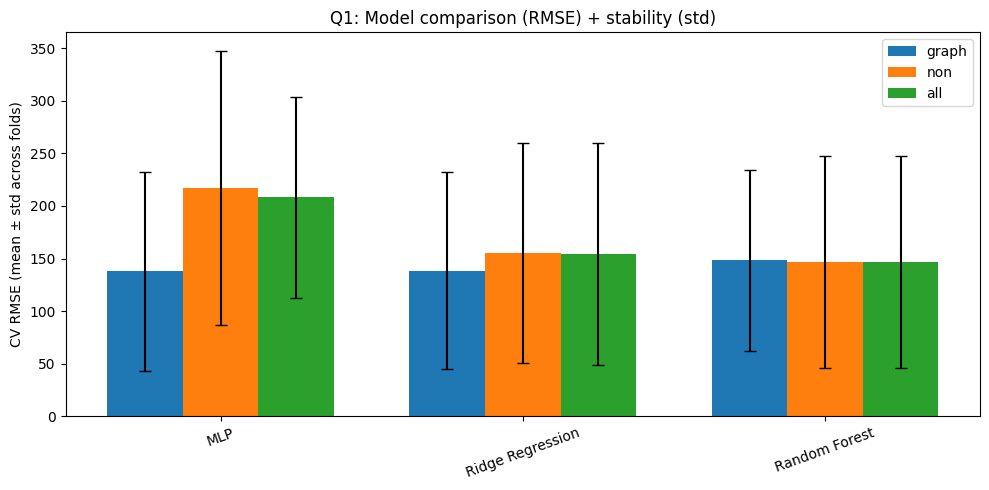

In [78]:
import matplotlib.pyplot as plt

def plot_rmse_bar(cv_summary):
    dfp = cv_summary.copy()
    order_models = dfp.groupby("Model")["RMSE_mean"].min().sort_values().index.tolist()
    feat_order = ["graph", "non", "all"]

    x = np.arange(len(order_models))
    width = 0.25

    plt.figure(figsize=(10, 5))

    for k, feat in enumerate(feat_order):
        sub = dfp[dfp["Features"] == feat].set_index("Model").reindex(order_models)
        plt.bar(x + (k-1)*width, sub["RMSE_mean"].to_numpy(), width=width, yerr=sub["RMSE_std"].to_numpy(), capsize=4, label=feat)

    plt.xticks(x, order_models, rotation=20)
    plt.ylabel("CV RMSE (mean ± std across folds)")
    plt.title("Q1: Model comparison (RMSE) + stability (std)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_rmse_bar(cv_summary)


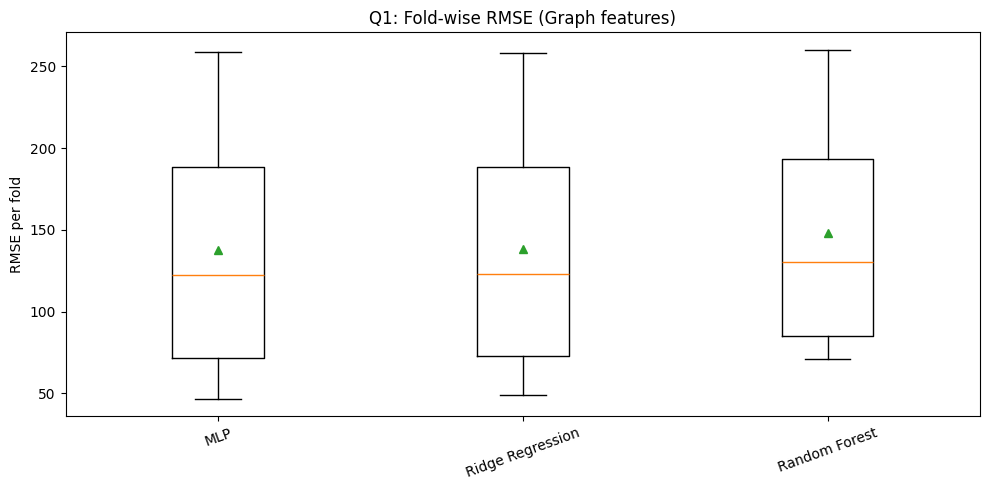

In [79]:
def plot_rmse_box(fold_df, title="Fold-wise RMSE boxplot"):
    # pivot to have one column per model (nice boxplot)
    # (we keep one feature_set at a time for readability)
    models_order = fold_df.groupby("Model")["RMSE"].median().sort_values().index.tolist()
    data = [fold_df[fold_df["Model"] == m]["RMSE"].to_numpy() for m in models_order]

    plt.figure(figsize=(10, 5))
    plt.boxplot(data, labels=models_order, showmeans=True)
    plt.ylabel("RMSE per fold")
    plt.title(title)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

# Example: graph-only boxplot
plot_rmse_box(folds_g, title="Q1: Fold-wise RMSE (Graph features)")


In [80]:
from scipy.stats import wilcoxon

def wilcoxon_compare(fold_df, model_a, model_b, metric="RMSE"):
    """
    Paired Wilcoxon signed-rank test across folds.
    Assumes same folds for both models.
    """
    a = fold_df[fold_df["Model"] == model_a].sort_values("Fold")[metric].to_numpy()
    b = fold_df[fold_df["Model"] == model_b].sort_values("Fold")[metric].to_numpy()

    # sanity
    assert len(a) == len(b), "Fold counts differ!"
    if np.allclose(a, b):
        return {"model_a": model_a, "model_b": model_b, "metric": metric, "pvalue": 1.0, "note": "identical values"}

    stat, p = wilcoxon(a, b, alternative="two-sided")
    return {
        "model_a": model_a,
        "model_b": model_b,
        "metric": metric,
        "pvalue": float(p),
        "a_mean": float(np.mean(a)),
        "b_mean": float(np.mean(b)),
        "a_folds": a,
        "b_folds": b
    }


In [81]:
# choose best two by mean RMSE on graph
best_two = summary_g.sort_values("RMSE_mean")["Model"].head(2).tolist()
print(best_two)
test_res = wilcoxon_compare(folds_g, best_two[0], best_two[1], metric="RMSE")
print(test_res)

['MLP', 'Ridge Regression']
{'model_a': 'MLP', 'model_b': 'Ridge Regression', 'metric': 'RMSE', 'pvalue': 0.625, 'a_mean': 137.68444673701885, 'b_mean': 138.2477239671784, 'a_folds': array([258.72865351, 165.37435919,  79.81752426,  46.81724998]), 'b_folds': array([258.14630377, 165.05821141,  80.65299785,  49.13338284])}


In [82]:
def time_ordered_learning_curve_one_fold(
        df, y, folds, model_factory,
        feature_set="graph",
        fractions=(0.2, 0.4, 0.6, 0.8, 1.0),
        fold_index=-1
):
    """
    Learning curve on one chosen fold:
    - Use increasing prefixes of the training set (time-consistent)
    - Evaluate on the fold's validation set
    Returns BOTH RMSE and MAE for train and validation.
    """
    train_idx, val_idx = folds[fold_index]

    # Sort training indices by year to maintain time order in the prefix
    train_years = df.iloc[train_idx]["year"].to_numpy()
    train_idx_sorted = train_idx[np.argsort(train_years)]

    df_va = df.iloc[val_idx]
    y_va = y[val_idx]

    train_rmse, val_rmse = [], []
    train_mae,  val_mae  = [], []
    sizes = []

    for frac in fractions:
        n = max(50, int(len(train_idx_sorted) * frac))  # at least 50 samples
        sub_idx = train_idx_sorted[:n]

        df_tr = df.iloc[sub_idx]
        y_tr = y[sub_idx]

        # Build features using train subset only
        Xtr_list, Xva_list = [], []

        if feature_set in ("graph", "all"):
            author_features = build_author_features(df_tr)
            Xtr_g = df_tr["authors"].apply(lambda a: paper_graph_features(a, author_features)).apply(pd.Series).fillna(0)
            Xva_g = df_va["authors"].apply(lambda a: paper_graph_features(a, author_features)).apply(pd.Series).fillna(0)
            Xtr_list.append(Xtr_g); Xva_list.append(Xva_g)

        if feature_set in ("non", "all"):
            stats_non = build_non_graph_stats(df_tr)
            Xtr_n = make_non_graph_features(df_tr, stats_non).fillna(0)
            Xva_n = make_non_graph_features(df_va, stats_non).fillna(0)
            Xtr_list.append(Xtr_n); Xva_list.append(Xva_n)

        Xtr = pd.concat(Xtr_list, axis=1, join="inner")
        Xva = pd.concat(Xva_list, axis=1, join="inner")

        model = model_factory()
        model.fit(Xtr, y_tr)

        pred_tr = model.predict(Xtr)
        pred_va = model.predict(Xva)

        # Metrics
        train_rmse.append(float(np.sqrt(mean_squared_error(y_tr, pred_tr))))
        val_rmse.append(float(np.sqrt(mean_squared_error(y_va, pred_va))))

        train_mae.append(float(mean_absolute_error(y_tr, pred_tr)))
        val_mae.append(float(mean_absolute_error(y_va, pred_va)))

        sizes.append(n)

    return pd.DataFrame({
        "train_size": sizes,
        "train_RMSE": train_rmse,
        "val_RMSE":   val_rmse,
        "train_MAE":  train_mae,
        "val_MAE":    val_mae
    })


In [83]:
def plot_learning_curves(metrics_by_model, title_prefix="Learning Curve"):
    """
    metrics_by_model: dict[str, pd.DataFrame]
      Each DataFrame must have columns:
      train_size, train_RMSE, val_RMSE, train_MAE, val_MAE
    Produces two separate figures: RMSE curve and MAE curve.
    """

    # RMSE figure
    plt.figure()
    for model_name, dfm in metrics_by_model.items():
        plt.plot(dfm["train_size"], dfm["train_RMSE"], label=f"{model_name} (train)")
        plt.plot(dfm["train_size"], dfm["val_RMSE"],   linestyle="--", label=f"{model_name} (val)")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.title(f"{title_prefix} — RMSE")
    plt.legend()
    plt.show()

    # MAE figure
    plt.figure()
    for model_name, dfm in metrics_by_model.items():
        plt.plot(dfm["train_size"], dfm["train_MAE"], label=f"{model_name} (train)")
        plt.plot(dfm["train_size"], dfm["val_MAE"],   linestyle="--", label=f"{model_name} (val)")
    plt.xlabel("Training set size")
    plt.ylabel("MAE")
    plt.title(f"{title_prefix} — MAE")
    plt.legend()
    plt.show()


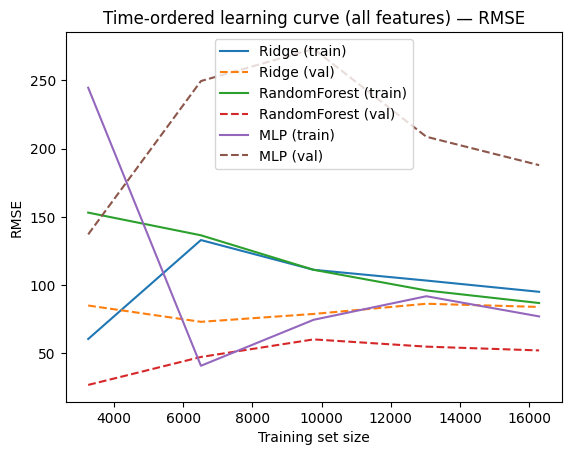

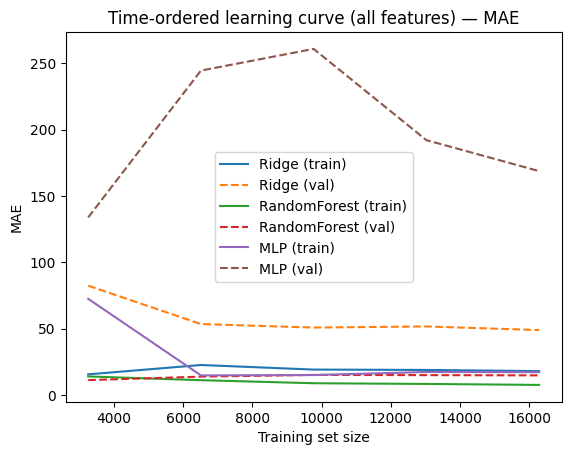

In [84]:
fractions = (0.2, 0.4, 0.6, 0.8, 1.0)
fold_index = -1
feature_set = "all"  # "graph", "non", or "all"

metrics_by_model = {
    "Ridge": time_ordered_learning_curve_one_fold(
        df, y, folds,
        model_factory=lambda: create_ridge_pipeline(),   
        feature_set=feature_set,
        fractions=fractions,
        fold_index=fold_index
    ),
    "RandomForest": time_ordered_learning_curve_one_fold(
        df, y, folds,
        model_factory=lambda: create_rf_pipeline(),     
        feature_set=feature_set,
        fractions=fractions,
        fold_index=fold_index
    ),
    "MLP": time_ordered_learning_curve_one_fold(
        df, y, folds,
        model_factory=lambda: create_mlp_pipeline(),     
        feature_set=feature_set,
        fractions=fractions,
        fold_index=fold_index
    )
}

plot_learning_curves(metrics_by_model, title_prefix=f"Time-ordered learning curve ({feature_set} features)")


In [88]:
def eval_on_holdout_test_prebuilt(models, Xtr, Xte, y_train, y_test, feature_set_name):
    """
    Fit each model once on prebuilt train features, evaluate once on prebuilt test features.
    """
    rows = []
    for model_name, model_factory in models.items():
        model = model_factory()
        model.fit(Xtr, y_train)
        pred = model.predict(Xte)

        rows.append({
            "Model": model_name,
            "Features": feature_set_name,
            "TEST_RMSE": float(np.sqrt(mean_squared_error(y_test, pred))),
            "TEST_MAE":  float(mean_absolute_error(y_test, pred))
        })

    return pd.DataFrame(rows).sort_values(["TEST_MAE", "TEST_RMSE"])


In [92]:
y_train = y
y_test  = np.nan_to_num(test_df["n_citation"].to_numpy(dtype=float),  nan=0.0)

Xtr_g = X_graph.fillna(0)
Xtr_n = X_non_graph.fillna(0)
Xtr_a = X_all.fillna(0)

# compute test features by applying the already-built train objects 
Xte_g = test_df["authors"].apply(lambda a: paper_graph_features(a, author_features_full)).apply(pd.Series).fillna(0)
Xte_n = test_df.apply(lambda row: paper_non_graph_features(row["authors"], row["venue"]), axis=1).apply(pd.Series).fillna(0)
Xte_a = pd.concat([Xte_g, Xte_n], axis=1)
# align columns
Xte_g = Xte_g.reindex(columns=Xtr_g.columns, fill_value=0)
Xte_n = Xte_n.reindex(columns=Xtr_n.columns, fill_value=0)
Xte_a = Xte_a.reindex(columns=Xtr_a.columns, fill_value=0)
feat_sets = {
    "graph": (Xtr_g, Xte_g),
    "non":   (Xtr_n, Xte_n),
    "all":   (Xtr_a, Xte_a),
}
# evaluate 
results = []
for feat_name, (Xtr, Xte) in feat_sets.items():
    results.append(eval_on_holdout_test_prebuilt(models, Xtr, Xte, y_train, y_test, feat_name))

test_summary = pd.concat(results, ignore_index=True)
print(test_summary)

a
b
              Model Features   TEST_RMSE   TEST_MAE
0               MLP    graph   43.946692  39.341226
1  Ridge Regression    graph   45.352154  40.387223
2     Random Forest    graph   75.482500  47.405819
3     Random Forest      non   45.500384  12.974546
4  Ridge Regression      non   54.717947  35.739063
5               MLP      non  106.487473  88.404955
6     Random Forest      all   46.158121  13.039750
7  Ridge Regression      all   52.555504  32.434689
8               MLP      all   78.637765  63.533157


In [93]:
def plot_test_mae_bar(test_summary):
    dfp = test_summary.copy()

    # Order models by MAE using ALL features
    order_models = (
        dfp[dfp["Features"] == "all"]
        .sort_values("TEST_MAE")["Model"]
        .tolist()
    )

    feat_order = ["graph", "non", "all"]
    x = np.arange(len(order_models))
    width = 0.25

    plt.figure(figsize=(10, 5))
    for k, feat in enumerate(feat_order):
        sub = dfp[dfp["Features"] == feat].set_index("Model").reindex(order_models)
        plt.bar(
            x + (k - 1) * width,
            sub["TEST_MAE"].to_numpy(),
            width=width,
            label=feat
        )

    plt.xticks(x, order_models, rotation=20)
    plt.ylabel("Hold-out TEST MAE")
    plt.title("Final hold-out evaluation (>2015): MAE by model and feature set")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_test_rmse_bar(test_summary):
    dfp = test_summary.copy()

    # Order models by RMSE using ALL features
    order_models = (
        dfp[dfp["Features"] == "all"]
        .sort_values("TEST_RMSE")["Model"]
        .tolist()
    )

    feat_order = ["graph", "non", "all"]
    x = np.arange(len(order_models))
    width = 0.25

    plt.figure(figsize=(10, 5))
    for k, feat in enumerate(feat_order):
        sub = dfp[dfp["Features"] == feat].set_index("Model").reindex(order_models)
        plt.bar(
            x + (k - 1) * width,
            sub["TEST_RMSE"].to_numpy(),
            width=width,
            label=feat
        )

    plt.xticks(x, order_models, rotation=20)
    plt.ylabel("Hold-out TEST RMSE")
    plt.title("Final hold-out evaluation (>2015): RMSE by model and feature set")
    plt.legend()
    plt.tight_layout()
    plt.show()


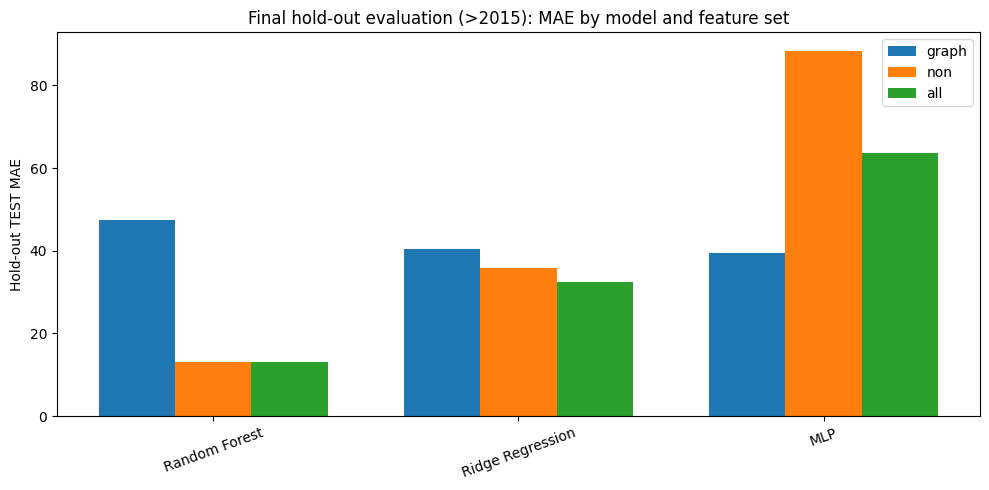

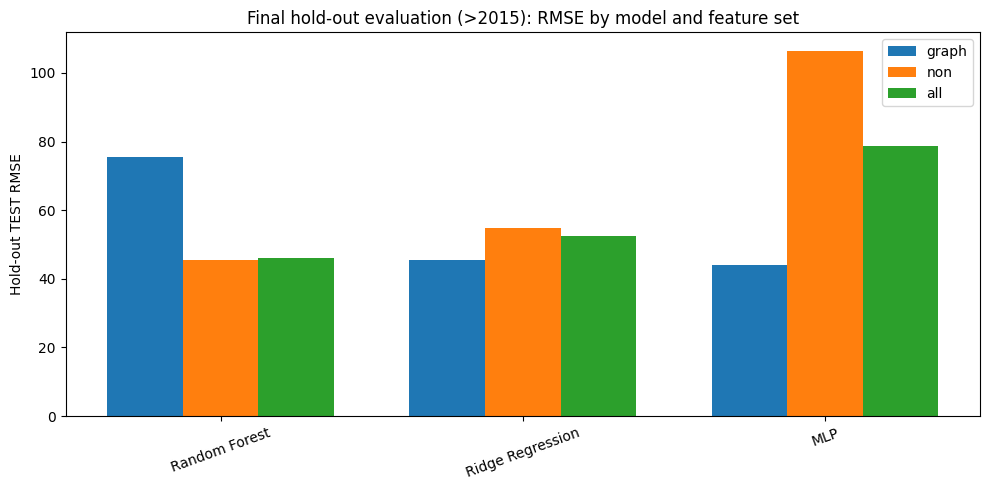

In [94]:
plot_test_mae_bar(test_summary)
plot_test_rmse_bar(test_summary)

In [103]:
def ridge_importance_cv(fold_cache, ridge_factory, feature_set="graph"):
    rows = []

    for fi, (Xtr_g, Xva_g, Xtr_n, Xva_n, y_tr, y_va) in enumerate(fold_cache):
        if feature_set == "graph":
            Xtr = Xtr_g
        elif feature_set == "non":
            Xtr = Xtr_n
        elif feature_set == "all":
            Xtr = pd.concat([Xtr_g, Xtr_n], axis=1)
        else:
            raise ValueError("feature_set must be 'graph', 'non', or 'all'")

        m = ridge_factory()
        m.fit(Xtr, y_tr)

        coef = m.named_steps["model"].coef_
        imp = np.abs(coef)

        for feat, val in zip(Xtr.columns, imp):
            rows.append({"fold": fi, "feature": feat, "importance": float(val)})

    df = pd.DataFrame(rows)
    return (df.groupby("feature")["importance"]
            .agg(["mean", "std"])
            .reset_index()
            .sort_values("mean", ascending=False))

In [104]:
from sklearn.inspection import permutation_importance

def perm_importance_cv(fold_cache, model_factory, feature_set="graph",
                       scoring="neg_mean_absolute_error", n_repeats=5, random_state=42):
    rows = []

    for fi, (Xtr_g, Xva_g, Xtr_n, Xva_n, y_tr, y_va) in enumerate(fold_cache):
        if feature_set == "graph":
            Xtr, Xva = Xtr_g, Xva_g
        elif feature_set == "non":
            Xtr, Xva = Xtr_n, Xva_n
        elif feature_set == "all":
            Xtr = pd.concat([Xtr_g, Xtr_n], axis=1)
            Xva = pd.concat([Xva_g, Xva_n], axis=1)
        else:
            raise ValueError("feature_set must be 'graph', 'non', or 'all'")

        m = model_factory()
        m.fit(Xtr, y_tr)

        r = permutation_importance(
            m, Xva, y_va,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1
        )

        for feat, val in zip(Xva.columns, r.importances_mean):
            rows.append({"fold": fi, "feature": feat, "importance": float(val)})

    df = pd.DataFrame(rows)
    return (df.groupby("feature")["importance"]
            .agg(["mean", "std"])
            .reset_index()
            .sort_values("mean", ascending=False))


In [108]:
ridge_imp = ridge_importance_cv(fold_cache, models["Ridge Regression"], feature_set="graph")

rf_imp = perm_importance_cv(
    fold_cache, models["Random Forest"],
    feature_set="graph",
    scoring="neg_mean_absolute_error",
    n_repeats=5
)

mlp_imp = perm_importance_cv(
    fold_cache, models["MLP"],
    feature_set="graph",
    scoring="neg_mean_absolute_error",
    n_repeats=5
)

mlp_imp_ng = perm_importance_cv(
    fold_cache, models["MLP"],
    feature_set="non",
    scoring="neg_mean_absolute_error",
    n_repeats=5
)

print("Ridge top-10:\n", ridge_imp.head(10))
print("RF top-10:\n", rf_imp.head(10))
print("MLP top-10:\n", mlp_imp.head(10))
print("MLP top-10 non-graph:\n", mlp_imp_ng.head(10))

Ridge top-10:
                  feature       mean       std
1          max_closeness  22.626920  5.266215
7         mean_closeness  18.370767  8.062746
11  mean_weighted_degree  16.780682  8.321946
3     max_component_size  14.858963  7.835141
9    mean_component_size  14.858963  7.835141
5    max_weighted_degree  12.874751  7.350266
8        mean_clustering   9.320079  3.937493
4           max_pagerank   8.420165  9.263510
10         mean_pagerank   5.452304  3.700380
2         max_clustering   5.446293  4.467030
RF top-10:
                  feature       mean        std
10         mean_pagerank  16.352268  10.405616
7         mean_closeness  13.076287   9.078182
1          max_closeness   9.800609   9.616974
4           max_pagerank   8.016934   5.249623
3     max_component_size   5.622515   4.716553
9    mean_component_size   5.052756   4.739536
0        max_betweenness   3.108105   5.667421
2         max_clustering   3.090879   1.833087
8        mean_clustering   2.992718   2.0716

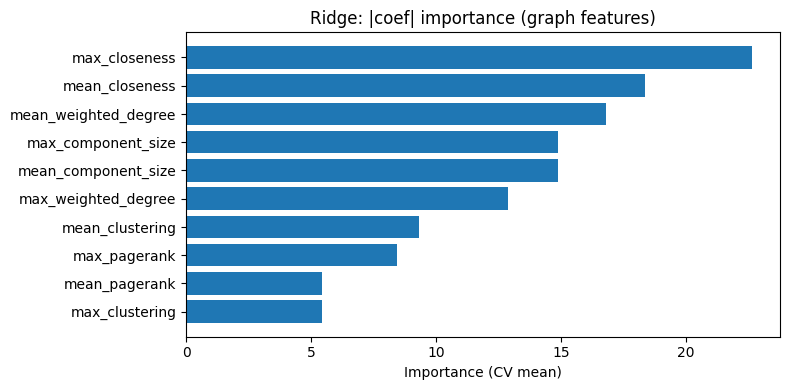

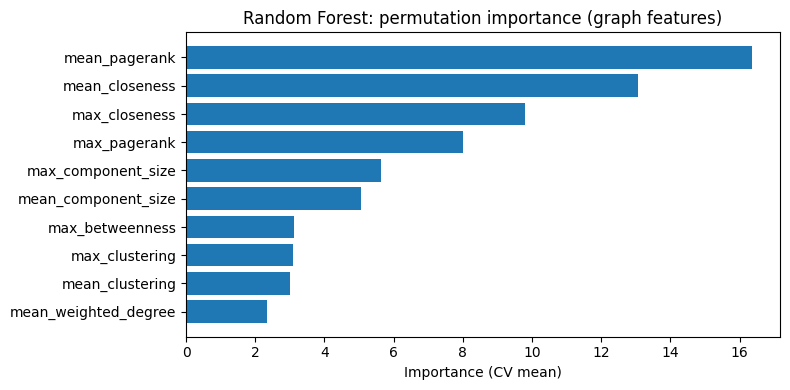

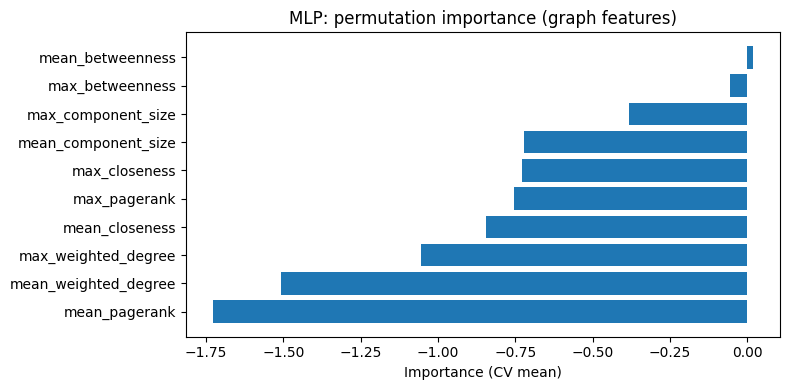

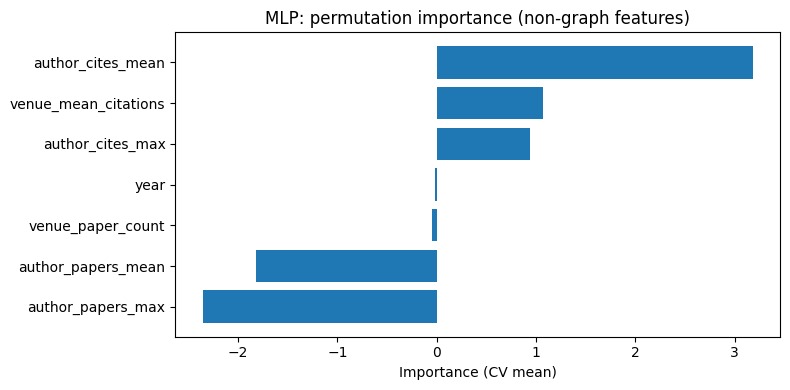

In [109]:
import matplotlib.pyplot as plt

def plot_topk_importance(df_imp, title, k=10, col="mean"):
    d = df_imp.head(k).copy()
    plt.figure(figsize=(8, 4))
    plt.barh(d["feature"][::-1], d[col][::-1])
    plt.title(title)
    plt.xlabel("Importance (CV mean)")
    plt.tight_layout()
    plt.show()

plot_topk_importance(ridge_imp, "Ridge: |coef| importance (graph features)", k=10)
plot_topk_importance(rf_imp, "Random Forest: permutation importance (graph features)", k=10)
plot_topk_importance(mlp_imp, "MLP: permutation importance (graph features)", k=10)
plot_topk_importance(mlp_imp_ng, "MLP: permutation importance (non-graph features)", k=10)


In [110]:
def topk_set(df_imp, k=10):
    return set(df_imp.head(k)["feature"].tolist())

def jaccard(a, b):
    return len(a & b) / max(1, len(a | b))

top_ridge = topk_set(ridge_imp, 5)
top_rf    = topk_set(rf_imp, 5)
top_mlp   = topk_set(mlp_imp, 5)

print("Jaccard(top5) Ridge vs RF:", jaccard(top_ridge, top_rf))
print("Jaccard(top5) Ridge vs MLP:", jaccard(top_ridge, top_mlp))
print("Jaccard(top5) RF vs MLP:", jaccard(top_rf, top_mlp))


Jaccard(top5) Ridge vs RF: 0.42857142857142855
Jaccard(top5) Ridge vs MLP: 0.42857142857142855
Jaccard(top5) RF vs MLP: 0.25
